In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder



In [2]:
df = pd.read_csv("../data/Kangaroo.csv")

In [4]:
postcode_locality_df = df[["postCode", "locality"]].dropna()

# Convert postcode to string (important for consistent key formatting)
postcode_locality_df["postCode"] = postcode_locality_df["postCode"].astype(str)

# Drop duplicates, keeping the first occurrence
postcode_locality_df = postcode_locality_df.drop_duplicates(subset=["postCode"])

# Create the dictionary
postcode_locality_dict = dict(zip(postcode_locality_df["postCode"], postcode_locality_df["locality"]))

# Optional: Preview
print(postcode_locality_dict)

{'1040': 'Etterbeek', '1020': 'Laeken', '1030': 'Schaerbeek', '1000': 'Bruxelles', '1060': 'Saint-Gilles', '1050': 'IXELLES', '1081': 'KOEKELBERG', '1080': 'Molenbeek-Saint-Jean', '1082': 'Berchem-Sainte-Agathe', '1070': 'Anderlecht', '1083': 'Ganshoren', '1090': 'Jette', '1180': 'Uccle', '6700': 'ARLON', '1210': 'Saint-Josse-ten-Noode', '2660': 'HOBOKEN', '2400': 'MOL', '1800': 'VILVOORDE', '9800': 'Deinze', '8301': 'Heist-aan-Zee', '2830': 'Willebroek', '2060': 'ANTWERPEN', '2300': 'Turnhout', '3290': 'DIEST', '9000': 'Gent', '2100': 'DEURNE', '4100': 'Seraing', '4480': 'Engis', '4052': 'Chaudfontaine', '1140': 'Evere', '4102': 'Seraing', '4400': 'Flémalle', '4042': 'Herstal Liers', '9190': 'STEKENE', '2600': 'Berchem', '2440': 'GEEL', '2240': 'ZANDHOVEN', '9940': 'Evergem', '9600': 'Ronse', '8760': 'Meulebeke', '1410': 'Waterloo', '9550': 'Herzele', '1190': 'Forest', '2500': 'LIER', '3500': 'Hasselt', '8370': 'BLANKENBERGE', '2650': 'EDEGEM', '4851': 'Plombières', '4041': 'Herstal',

In [3]:
# Step 3: Initial Exploration
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.isnull().sum().sort_values(ascending=False))
print(df.describe())

(80368, 53)
Index(['Unnamed: 0', 'id', 'url', 'type', 'subtype', 'bedroomCount',
       'bathroomCount', 'province', 'locality', 'postCode', 'habitableSurface',
       'roomCount', 'monthlyCost', 'hasAttic', 'hasBasement',
       'hasDressingRoom', 'diningRoomSurface', 'hasDiningRoom',
       'buildingCondition', 'buildingConstructionYear', 'facedeCount',
       'floorCount', 'streetFacadeWidth', 'hasLift', 'floodZoneType',
       'heatingType', 'hasHeatPump', 'hasPhotovoltaicPanels',
       'hasThermicPanels', 'kitchenSurface', 'kitchenType', 'landSurface',
       'hasLivingRoom', 'livingRoomSurface', 'hasBalcony', 'hasGarden',
       'gardenSurface', 'gardenOrientation', 'parkingCountIndoor',
       'parkingCountOutdoor', 'hasAirConditioning', 'hasArmoredDoor',
       'hasVisiophone', 'hasOffice', 'toiletCount', 'hasSwimmingPool',
       'hasFireplace', 'hasTerrace', 'terraceSurface', 'terraceOrientation',
       'accessibleDisabledPeople', 'epcScore', 'price'],
      dtype='object')

In [4]:
unique_subtypes = df['subtype'].dropna().unique()
print(sorted(unique_subtypes))

['APARTMENT', 'APARTMENT_BLOCK', 'APARTMENT_GROUP', 'BUNGALOW', 'CASTLE', 'CHALET', 'COUNTRY_COTTAGE', 'DUPLEX', 'EXCEPTIONAL_PROPERTY', 'FARMHOUSE', 'FLAT_STUDIO', 'GROUND_FLOOR', 'HOUSE', 'HOUSE_GROUP', 'KOT', 'LOFT', 'MANOR_HOUSE', 'MANSION', 'MIXED_USE_BUILDING', 'OTHER_PROPERTY', 'PAVILION', 'PENTHOUSE', 'SERVICE_FLAT', 'TOWN_HOUSE', 'TRIPLEX', 'VILLA']


In [5]:
unique_subtypes = df['province'].dropna().unique()
print(sorted(unique_subtypes))

['Antwerp', 'Brussels', 'East Flanders', 'Flemish Brabant', 'Hainaut', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'Walloon Brabant', 'West Flanders']


In [10]:
# Check how landSurface and habitableSurface relate to property types
# Assume your type column is named 'type' or similar
land_missing = df['landSurface'].isna()
habitable_missing = df['habitableSurface'].isna()

# Create a summary DataFrame
summary = df.groupby('type').agg(
    count=('type', 'count'),
    landSurface_missing=('landSurface', lambda x: x.isna().mean()),
    habitableSurface_missing=('habitableSurface', lambda x: x.isna().mean())
).sort_values(by='count', ascending=False)

# Convert to percentages
summary['landSurface_missing_%'] = (summary['landSurface_missing'] * 100).round(2)
summary['habitableSurface_missing_%'] = (summary['habitableSurface_missing'] * 100).round(2)

# Keep only relevant columns
summary = summary[['count', 'landSurface_missing_%', 'habitableSurface_missing_%']]

# Print the summary
print(summary)

                 count  landSurface_missing_%  habitableSurface_missing_%
type                                                                     
HOUSE            45234                  12.59                       13.77
APARTMENT        31144                 100.00                        7.60
APARTMENT_GROUP   2425                 100.00                      100.00
HOUSE_GROUP       1565                 100.00                      100.00


In [8]:
summary = df.groupby('subtype').agg(
    count=('subtype', 'count'),
    landSurface_missing=('landSurface', lambda x: x.isna().mean()),
    habitableSurface_missing=('habitableSurface', lambda x: x.isna().mean())
).sort_values(by='count', ascending=False)

# Convert to percentages
summary['landSurface_missing_%'] = (summary['landSurface_missing'] * 100).round(2)
summary['habitableSurface_missing_%'] = (summary['habitableSurface_missing'] * 100).round(2)

# Select relevant columns
summary = summary[['count', 'landSurface_missing_%', 'habitableSurface_missing_%']]

print(summary)

                      count  landSurface_missing_%  habitableSurface_missing_%
subtype                                                                       
HOUSE                 33977                  11.95                       13.72
APARTMENT             23846                 100.00                        7.76
VILLA                  3769                   4.27                        9.60
APARTMENT_BLOCK        2454                  31.01                       20.17
APARTMENT_GROUP        2425                 100.00                      100.00
MIXED_USE_BUILDING     1840                  20.43                       16.79
GROUND_FLOOR           1771                 100.00                        4.80
DUPLEX                 1691                 100.00                        5.80
HOUSE_GROUP            1565                 100.00                      100.00
FLAT_STUDIO            1381                 100.00                       10.57
PENTHOUSE              1265                 100.00  

In [14]:
df.shape

(80368, 53)

In [15]:
df_cleaned = df.drop(columns=["Unnamed: 0", "id", "url"])
str_cols = df_cleaned.select_dtypes(include='object').columns #Selects columns that are of type string or mixed object
for col in str_cols:
    df_cleaned[col] = df_cleaned[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

df_cleaned.describe(include='all') # Summary statistics of the data

,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,habitableSurface,roomCount,monthlyCost,...,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,terraceOrientation,accessibleDisabledPeople,epcScore,price
count,80368,80368,73558.000000,66672.000000,80368,80368,80368.000000,67783.000000,21948.000000,0.0,...,10387,55094.00000,1816,3044,47429,28599.000000,11262,0.0,65391,7.637000e+04
unique,4,26,NaN,NaN,11,5470,NaN,NaN,NaN,NaN,...,1,NaN,1,1,1,NaN,8,NaN,20,NaN
top,HOUSE,HOUSE,NaN,NaN,West Flanders,Antwerpen,NaN,NaN,NaN,NaN,...,True,NaN,True,True,True,NaN,SOUTH,NaN,B,NaN
freq,45234,33977,NaN,NaN,15515,1665,NaN,NaN,NaN,NaN,...,10387,NaN,1816,3044,47429,NaN,3143,NaN,13243,NaN
mean,NaN,NaN,3.008877,1.427121,NaN,NaN,5266.587199,178.499993,7.110443,NaN,...,NaN,1.80624,NaN,NaN,NaN,24.512710,NaN,NaN,NaN,4.476061e+05
std,NaN,NaN,1.833185,4.556189,NaN,NaN,3045.698904,820.878936,5.824088,NaN,...,NaN,8.41452,NaN,NaN,NaN,43.244643,NaN,NaN,NaN,5.115757e+05
min,NaN,NaN,1.000000,1.000000,NaN,NaN,1000.000000,6.000000,1.000000,NaN,...,NaN,1.00000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,3.141000e+03
25%,NaN,NaN,2.000000,1.000000,NaN,NaN,2330.000000,93.000000,1.000000,NaN,...,NaN,1.00000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,2.300000e+05
50%,NaN,NaN,3.000000,1.000000,NaN,NaN,4830.000000,140.000000,6.000000,NaN,...,NaN,2.00000,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,3.299000e+05
75%,NaN,NaN,4.000000,2.000000,NaN,NaN,8420.000000,200.000000,11.000000,NaN,...,NaN,2.00000,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,4.790000e+05


In [16]:
# Delete all rows with missing price
initial_shape = df_cleaned.shape
df_cleaned = df_cleaned.dropna(subset=['price'])
print(f"Deleted {initial_shape[0] - df_cleaned.shape[0]} rows without a price.")
print("New shape after dropping missing prices:", df_cleaned.shape)

Deleted 3998 rows without a price.
New shape after dropping missing prices: (76370, 50)


In [17]:
df_cleaned_copy = df_cleaned.copy()



In [ ]:
df[df['type'] == 'APARTMENT']['facedeCount'].value_counts(dropna=False)

### Exploratory Data Analysis

Categorize the features depending on their datatype (int, float, object) and
then calculate the number of them. 

In [28]:
obj = (df_cleaned.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (df_cleaned.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 28
Integer variables: 0
Float variables: 22


c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

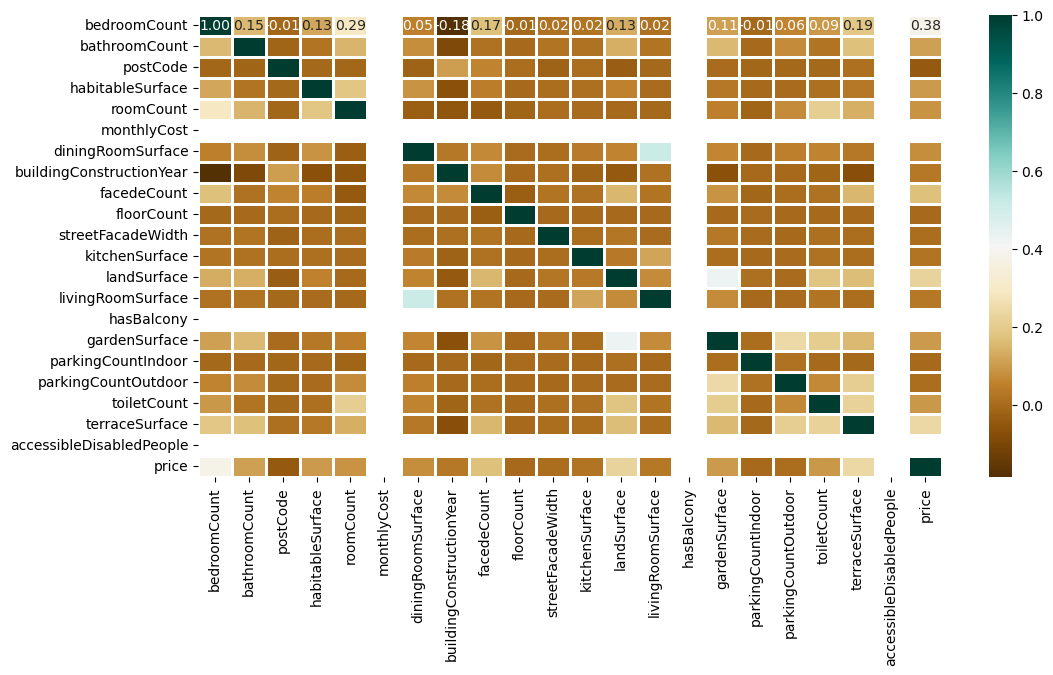

In [29]:
# Hearmap of correlations
numerical_dataset = df_cleaned.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

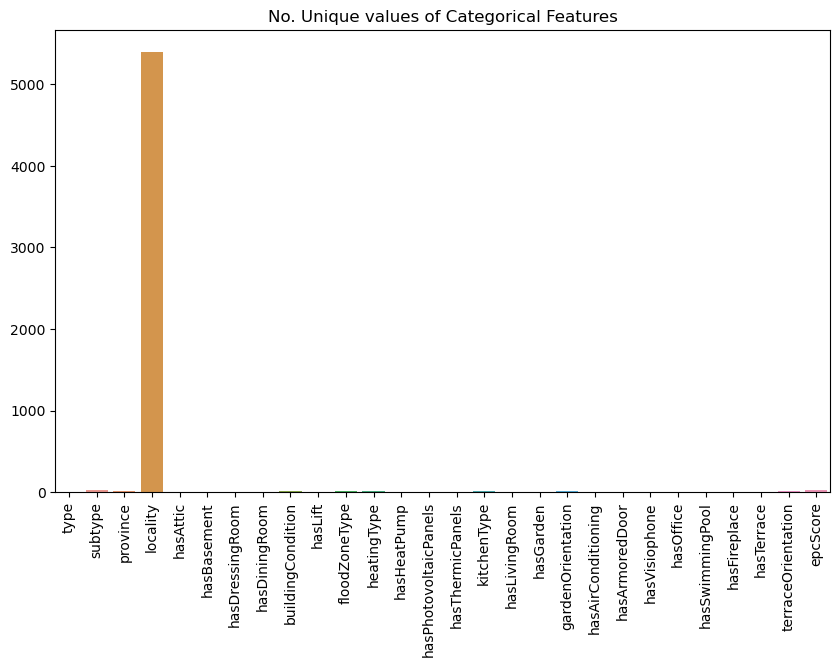

In [30]:
#unique values
unique_values = []
for col in object_cols:
  unique_values.append(df_cleaned[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


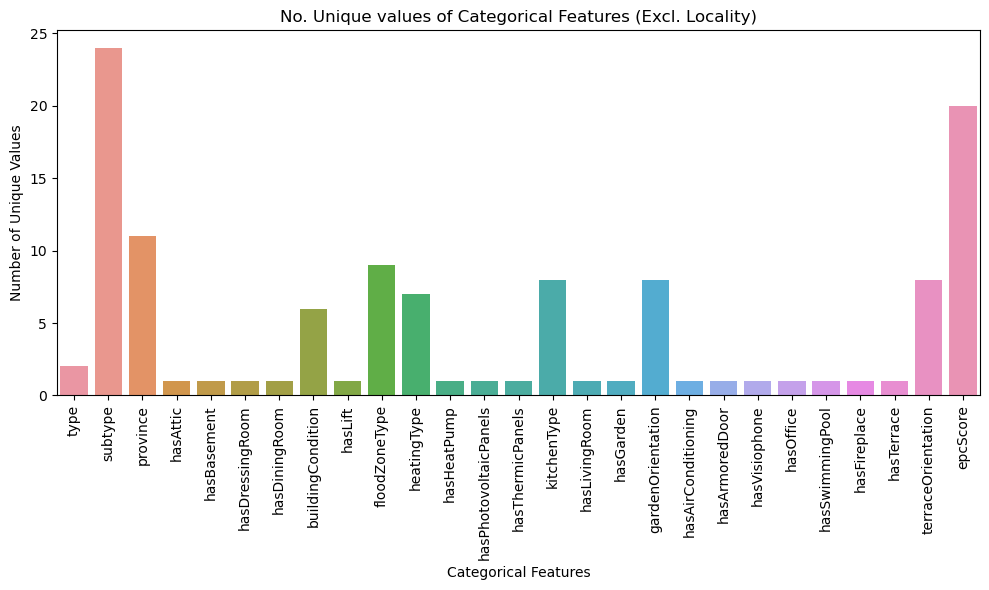

In [38]:
# Remove 'locality' from the list of categorical columns
object_cols_filtered = [col for col in object_cols if col != 'locality']

# Compute number of unique values (excluding 'locality')
unique_values = [df_cleaned[col].nunique() for col in object_cols_filtered]

# Plot
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features (Excl. Locality)')
plt.xticks(rotation=90)
sns.barplot(x=object_cols_filtered, y=unique_values)
plt.ylabel("Number of Unique Values")
plt.xlabel("Categorical Features")
plt.tight_layout()
plt.show()

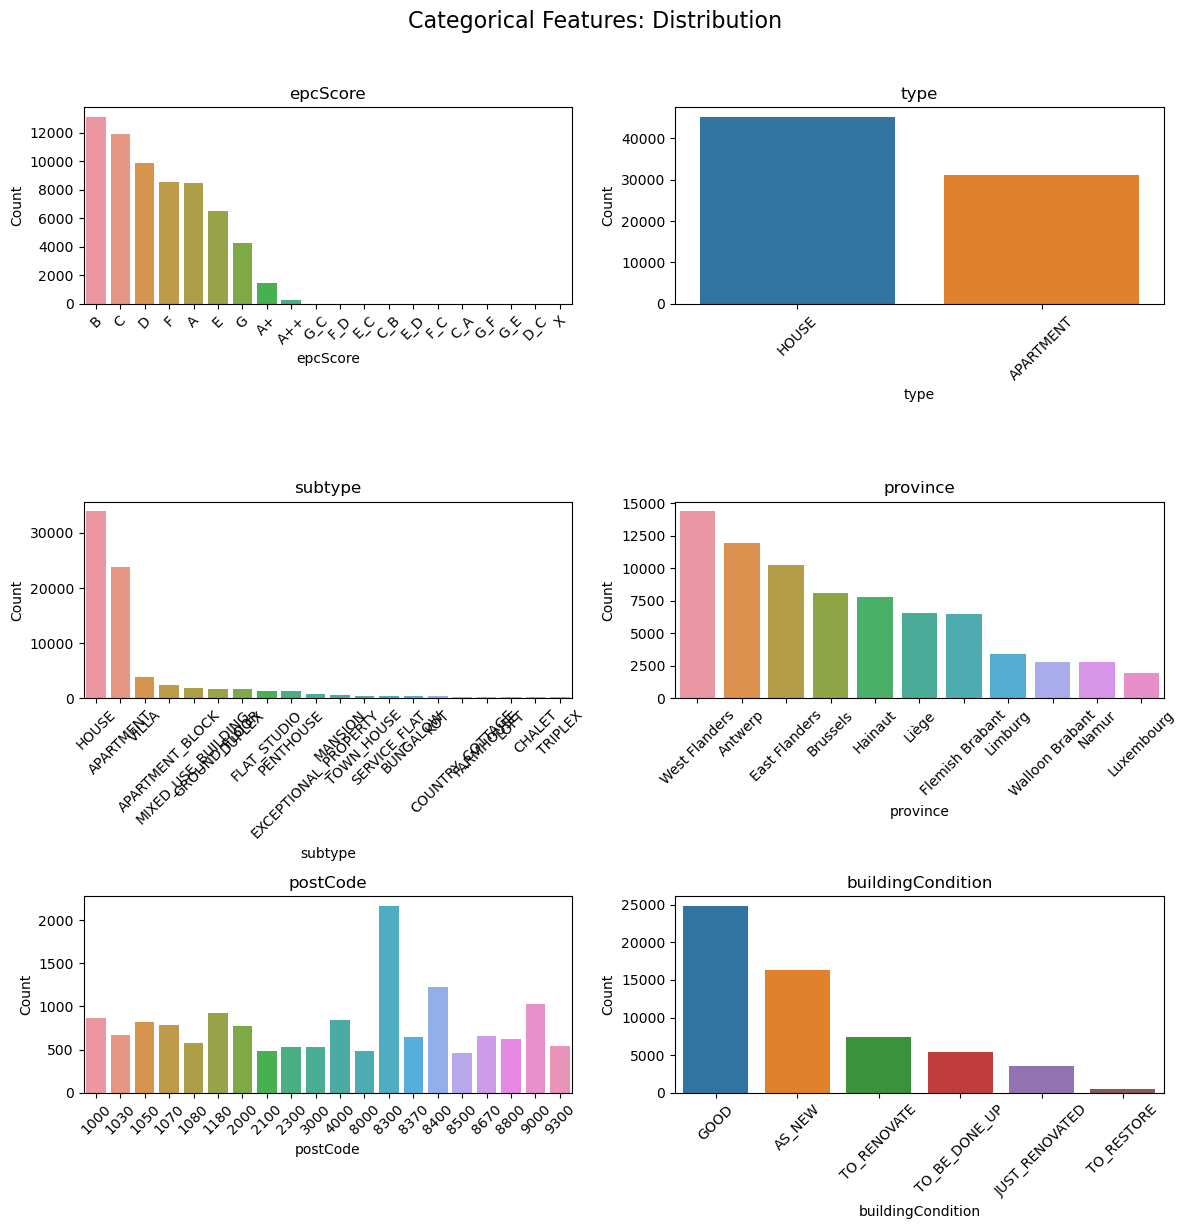

In [47]:
# List of important categorical features to plot
important_cats = ['epcScore', 'type', 'subtype', 'province', 'postCode', 'buildingCondition']

n_cols = 2  # You can adjust this to 2 or 4 depending on layout
n_rows = math.ceil(len(important_cats) / n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))
plt.suptitle('Categorical Features: Distribution', fontsize=16, y=1.02)

for index, col in enumerate(important_cats, start=1):
    plt.subplot(n_rows, n_cols, index)
    y = df_cleaned[col].value_counts().head(20)
    sns.barplot(x=y.index, y=y.values)
    plt.title(f'{col}')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

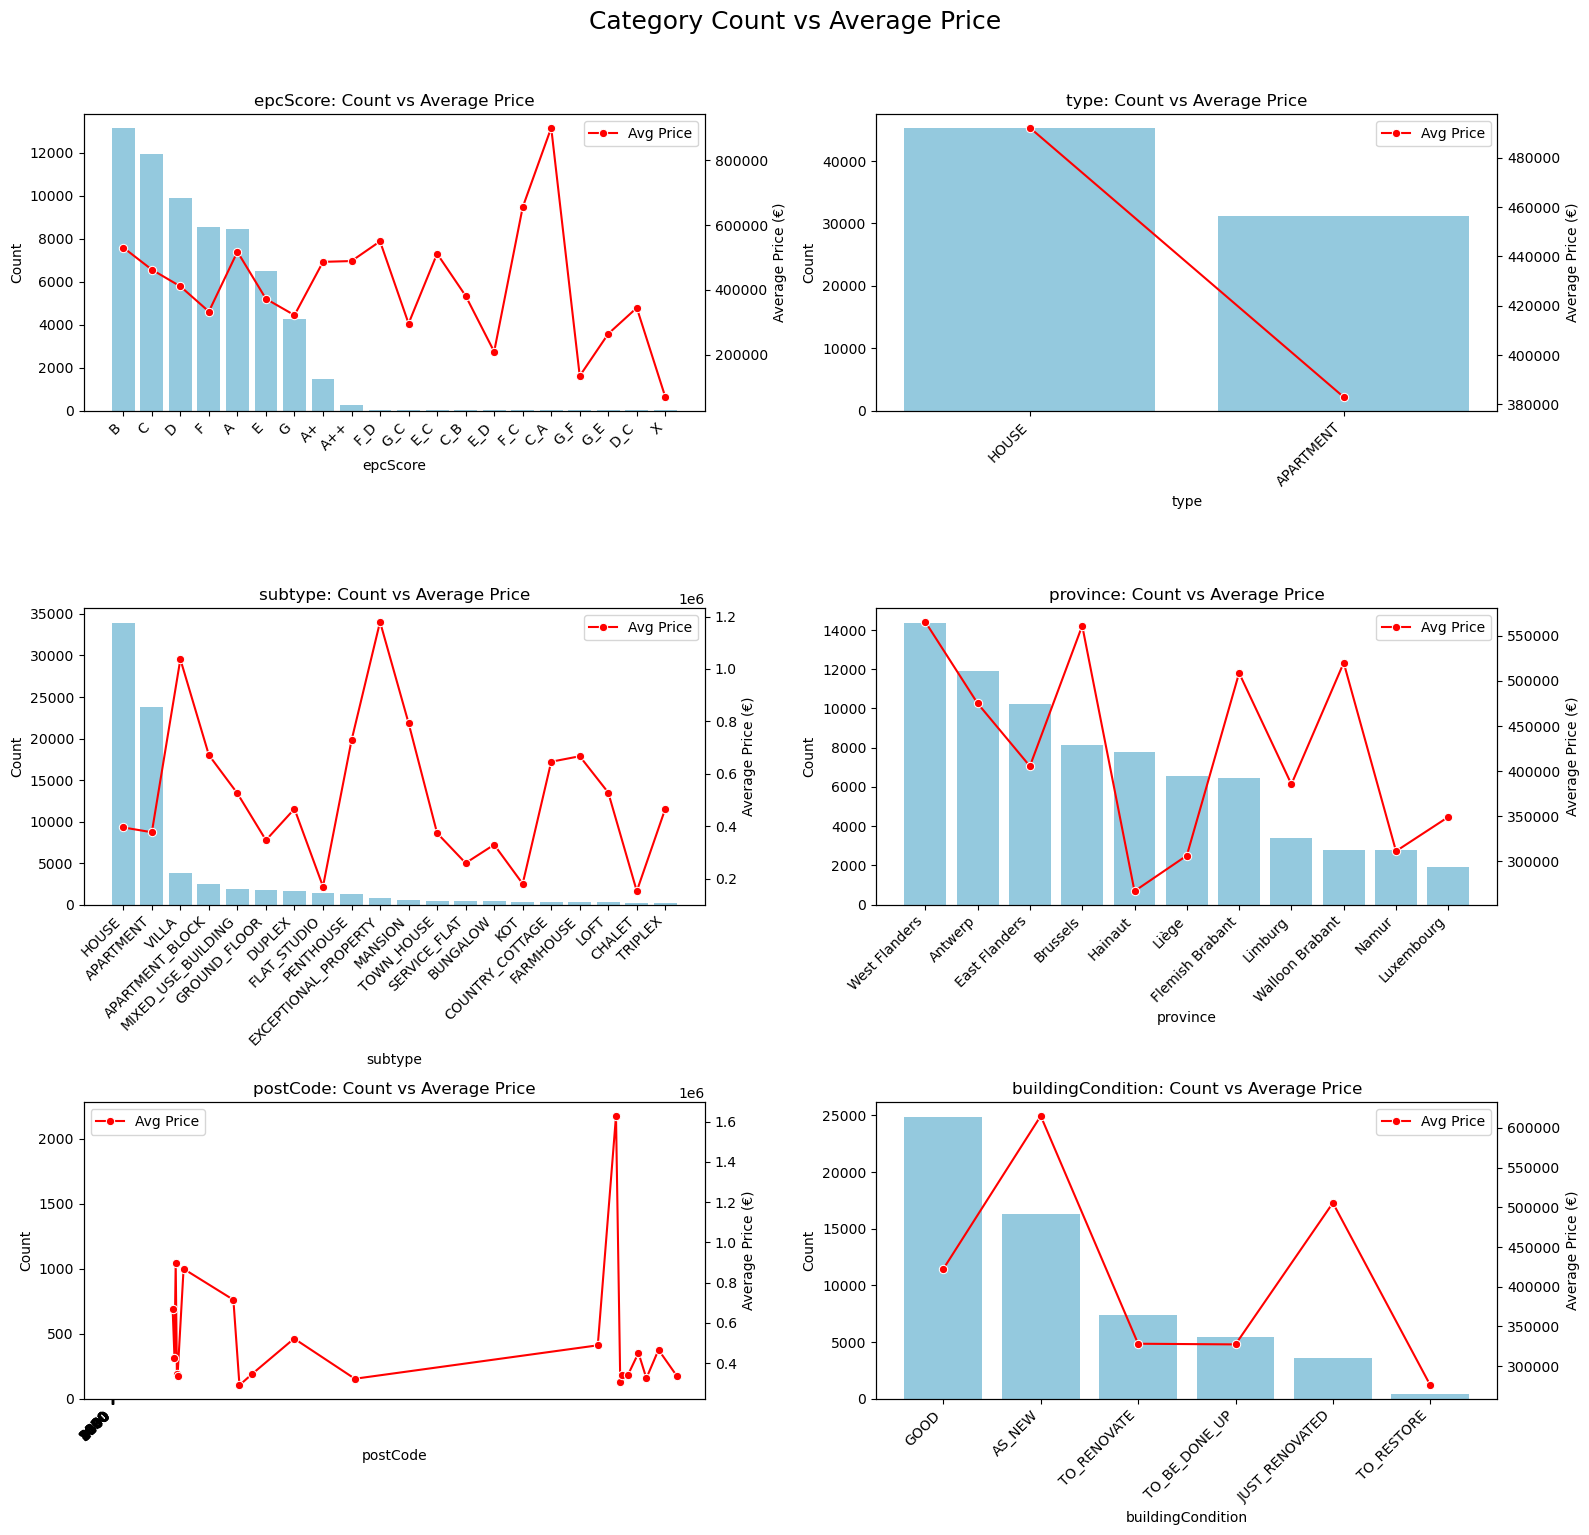

In [48]:
important_cats = ['epcScore', 'type', 'subtype', 'province', 'postCode', 'buildingCondition']

n_cols = 2
n_rows = math.ceil(len(important_cats) / n_cols)

plt.figure(figsize=(n_cols * 8, n_rows * 5))
plt.suptitle("Category Count vs Average Price", fontsize=18, y=1.02)

for index, col in enumerate(important_cats, start=1):
    plt.subplot(n_rows, n_cols, index)
    
    # Group data
    count_series = df_cleaned[col].value_counts()
    price_series = df_cleaned.groupby(col)['price'].mean()
    
    # Keep only categories present in both
    common_cats = count_series.index.intersection(price_series.index)
    
    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        'Count': count_series[common_cats],
        'AvgPrice': price_series[common_cats]
    }).sort_values(by='Count', ascending=False).head(20)

    # Plotting with twin axes
    ax1 = sns.barplot(x=plot_df.index, y='Count', data=plot_df, color='skyblue')
    ax1.set_ylabel("Count")
    ax1.set_xlabel(col)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    ax2 = ax1.twinx()
    sns.lineplot(x=plot_df.index, y='AvgPrice', data=plot_df, ax=ax2, color='red', marker="o", label='Avg Price')
    ax2.set_ylabel("Average Price (€)")

    plt.title(f"{col}: Count vs Average Price")

plt.tight_layout()
plt.show()

However, Zulkifley et al. (2020) state that the predictive variables in real estate applications can be divided into four groups, namely structural, location, socioeconomic and macroeconomic variables. Factors that can be associated with these groupings can as such be considered to have some predictive value in predicting rents or property prices. Structural variables include characteristics of the property, such as surface livable, number of bedrooms and bathrooms. Location factors are data regarding geographical location such as proximity to parks, supermarkets, and universities, among others. Socioeconomic factors are considered factors about the neighborhood of the property, such as average income and education level of neighborhoods. However, the boundary between location and socioeconomic factors is thin, so they are often taken together, as also observed in the reviewed studies above. Lastly, the macroeconomic variables that attempt to include the impact of economic cycle, such as the mortgage rate. However, macroeconomic features are less used as observed in the work of Zulkifley et al. (2020). According to the research of Chiwuzie et al. (2021), one possible explanation for this is the inconsistent and conflicting findings regarding the direction of the relation between the studied macroeconomic variables and property prices. Another argument for this observation is that it can be more difficult to include macroeconomic variables in prediction models since they are often less directly related to real estate prices than location factors and property characteristics are (Warisse, 2017). Among those four groupings, structural and location factors are the two principal categories (Krämer et al., 2021). These two types of variable groupings were used in essentially all the studies that are referenced in the ‘ML models’ section above.

c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dieu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


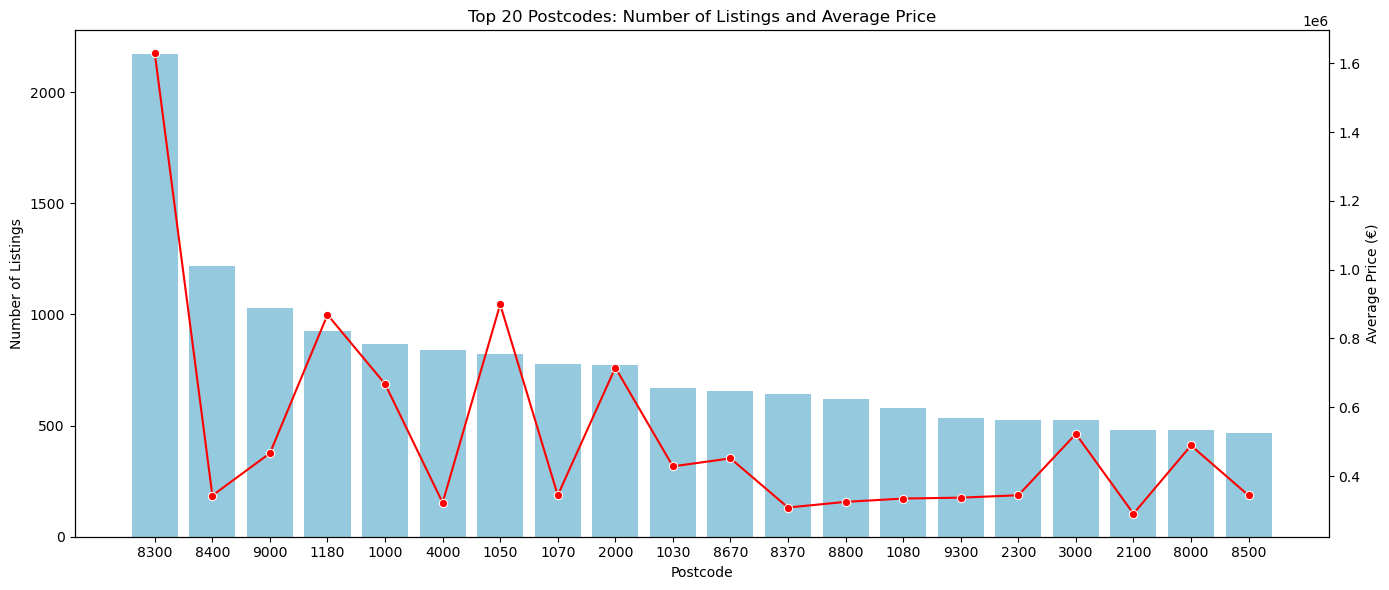

In [ ]:
df_cleaned['postCode'] = df_cleaned['postCode'].astype(str)

# Get top 20 most frequent postCodes
top_postCodes = df_cleaned['postCode'].value_counts().head(20).index

# Create a new DataFrame with counts and average prices
postCode_plot_df = (
    df_cleaned[df_cleaned['postCode'].isin(top_postCodes)]
    .groupby('postCode')
    .agg(count=('postCode', 'size'), avg_price=('price', 'mean'))
    .sort_values('count', ascending=False)
)

# Plot: Bar for count, line for average price
fig, ax1 = plt.subplots(figsize=(14, 6))

# Barplot for number of listings
sns.barplot(x=postCode_plot_df.index, y=postCode_plot_df['count'], color='skyblue', ax=ax1)
ax1.set_ylabel("Number of Listings")
ax1.set_xlabel("Postcode")
ax1.set_title("Top 20 Postcodes: Number of Listings and Average Price")

# Add lineplot for average price using a second y-axis
ax2 = ax1.twinx()
sns.lineplot(x=postCode_plot_df.index, y=postCode_plot_df['avg_price'], color='red', marker='o', ax=ax2)
ax2.set_ylabel("Average Price (€)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cleaning

In [19]:
missing_count = df_cleaned.isnull().sum()
missing_pct   = (missing_count / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct'  : missing_pct
}).sort_values('missing_pct', ascending=False)

print(missing_summary)  

                          missing_count  missing_pct
monthlyCost                       76370        95.03
hasBalcony                        76370        95.03
accessibleDisabledPeople          76370        95.03
hasAirConditioning                75246        93.63
hasSwimmingPool                   74554        92.77
hasDressingRoom                   73742        91.76
hasFireplace                      73326        91.24
hasThermicPanels                  73258        91.15
hasArmoredDoor                    72672        90.42
gardenOrientation                 70769        88.06
diningRoomSurface                 69471        86.44
hasHeatPump                       68897        85.73
hasPhotovoltaicPanels             68322        85.01
hasOffice                         65985        82.10
terraceOrientation                65108        81.01
hasAttic                          63856        79.45
hasDiningRoom                     62231        77.43
streetFacadeWidth                 60860       

In [20]:
cols_to_drop = df_cleaned.columns[
    (df_cleaned.isnull().mean() > 0.3) & (df_cleaned.columns != 'hasSwimmingPool')
]
df_cleaned = df_cleaned.drop(columns=cols_to_drop)
print("Dropped columns:", list(cols_to_drop))

Dropped columns: ['roomCount', 'monthlyCost', 'hasAttic', 'hasBasement', 'hasDressingRoom', 'diningRoomSurface', 'hasDiningRoom', 'buildingConstructionYear', 'facedeCount', 'floorCount', 'streetFacadeWidth', 'hasLift', 'floodZoneType', 'heatingType', 'hasHeatPump', 'hasPhotovoltaicPanels', 'hasThermicPanels', 'kitchenSurface', 'kitchenType', 'landSurface', 'hasLivingRoom', 'livingRoomSurface', 'hasBalcony', 'hasGarden', 'gardenSurface', 'gardenOrientation', 'parkingCountIndoor', 'parkingCountOutdoor', 'hasAirConditioning', 'hasArmoredDoor', 'hasVisiophone', 'hasOffice', 'hasFireplace', 'hasTerrace', 'terraceSurface', 'terraceOrientation', 'accessibleDisabledPeople']


In [24]:
df_cleaned.head(5)

,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,habitableSurface,buildingCondition,toiletCount,hasSwimmingPool,epcScore,price
0,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,100.0,GOOD,1.0,NaN,C,399000.0
1,HOUSE,HOUSE,4.0,2.0,Brussels,Etterbeek,1040,270.0,TO_BE_DONE_UP,3.0,NaN,E,895000.0
2,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,87.0,AS_NEW,1.0,NaN,F,465000.0
3,APARTMENT,APARTMENT,2.0,2.0,Brussels,Bruxelles,1040,104.0,AS_NEW,2.0,NaN,B,590000.0
4,APARTMENT,FLAT_STUDIO,1.0,1.0,Brussels,Etterbeek,1040,71.0,AS_NEW,1.0,NaN,E,289000.0


In [25]:
df_cleaned.shape

(76370, 13)

In [27]:
df_cleaned.columns

Index(['type', 'subtype', 'bedroomCount', 'bathroomCount', 'province',
       'locality', 'postCode', 'habitableSurface', 'buildingCondition',
       'toiletCount', 'hasSwimmingPool', 'epcScore', 'price'],
      dtype='object')

In [32]:
def map_postCode_to_region(postCode):
    if 1000 <= postCode <= 1299:
        return 'Brussels-Capital Region'
    elif (1300 <= postCode <= 1499) or (1500 <= postCode <= 1999) or (3000 <= postCode <= 3499):
        return 'Flemish Brabant'
    elif 2000 <= postCode <= 2999:
        return 'Antwerp'
    elif 3500 <= postCode <= 3999:
        return 'Limburg'
    elif 9000 <= postCode <= 9999:
        return 'East Flanders'
    elif 8000 <= postCode <= 8999:
        return 'West Flanders'
    elif 4000 <= postCode <= 4999:
        return 'Liège'
    elif 5000 <= postCode <= 5999:
        return 'Namur'
    elif 6000 <= postCode <= 6999:
        return 'Hainaut'
    elif 7000 <= postCode <= 7999:
        return 'Hainaut'
    elif 6600 <= postCode <= 6999:
        return 'Luxembourg'
    else:
        return 'Unknown'

In [33]:
province_postcode_counts = df[['postCode', 'province']].drop_duplicates().value_counts().reset_index(name='count')
print(province_postcode_counts.head())

   postCode    province  count
0      1000    Brussels      1
1      6927  Luxembourg      1
2      6952  Luxembourg      1
3      6951  Luxembourg      1
4      6950  Luxembourg      1


In [34]:
postcode_provinces = df.groupby('postCode')['province'].nunique()
print(postcode_provinces.value_counts())

province
1    1100
Name: count, dtype: int64


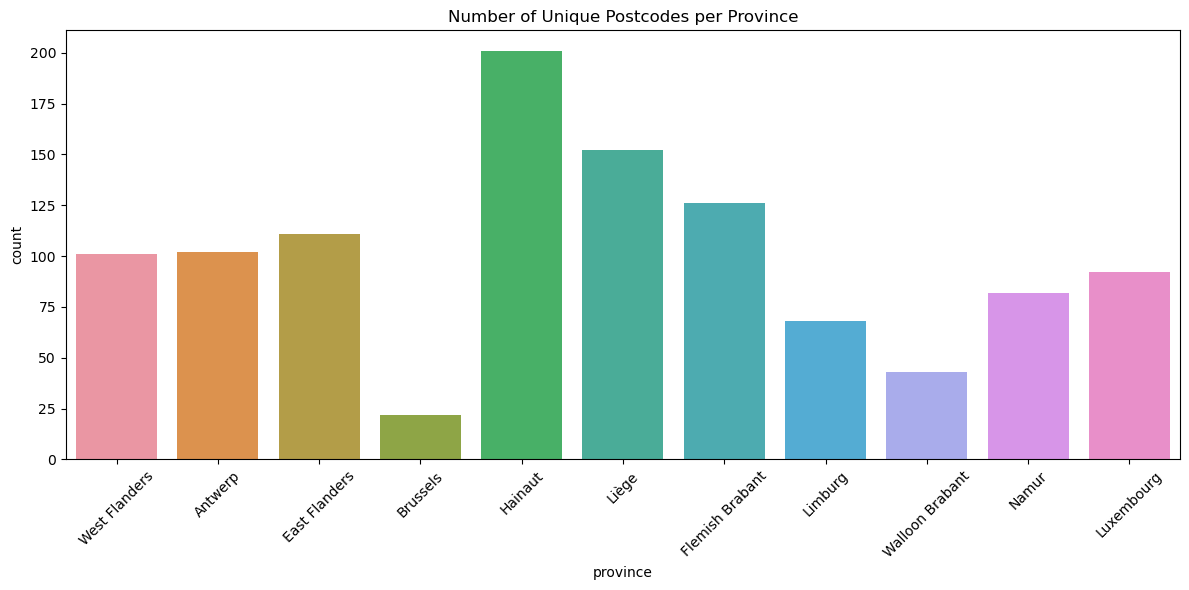

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot how many postcodes are in each province
plt.figure(figsize=(12,6))
sns.countplot(data=df.drop_duplicates(subset=['postCode', 'province']), x='province', order=df['province'].value_counts().index)
plt.title("Number of Unique Postcodes per Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### OneHotEncoder – For Label categorical features

In [16]:
s = (df_cleaned.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
      len(object_cols))

Categorical variables:
['type', 'subtype', 'province', 'locality', 'hasAttic', 'hasBasement', 'hasDressingRoom', 'hasDiningRoom', 'buildingCondition', 'hasLift', 'floodZoneType', 'heatingType', 'hasHeatPump', 'hasPhotovoltaicPanels', 'hasThermicPanels', 'kitchenType', 'hasLivingRoom', 'hasGarden', 'gardenOrientation', 'hasAirConditioning', 'hasArmoredDoor', 'hasVisiophone', 'hasOffice', 'hasSwimmingPool', 'hasFireplace', 'hasTerrace', 'terraceOrientation', 'epcScore']
No. of. categorical features:  28
